Original code from Jay

Can look at a sample LDA2vec visualization https://nbviewer.jupyter.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Model%20Talk.ipynb#topic=37&lambda=1&term=

# Imports

In [2]:
import os
import pickle

from pprint import pprint 
from collections import Counter
from urllib.parse import urlparse
import time
import datetime
from time import time
import string
import re

import numpy as np
import psycopg2
import pandas as pd
import spacy

from sklearn import svm
from sklearn.model_selection import train_test_split

from gensim.corpora.dictionary import Dictionary #load_from_text, doc2bow
from gensim.corpora import MmCorpus
from gensim.models.ldamodel import LdaModel

try:
    from stop_words import get_stop_words
    stopword_set = get_stop_words('en')
except ImportError:
    from nltk.corpus import stopwords
    stopword_set = set(stopwords.words('english'))

from nltk import wordpunct_tokenize
from nltk.corpus import stopwords

import keras
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Helpers

## ts

In [3]:
def ts(message=None):
    now = datetime.datetime.now().replace(microsecond=0)
    if message:
        print(f'{now}: {message}')
    else:
        print(now)

In [4]:
ts()
ts('hello')

2018-11-28 12:43:48
2018-11-28 12:43:48: hello


## _calculate_languages_ratios

In [5]:
def _calculate_languages_ratios(text):
    """
    Calculate probability of given text to be written in several languages and
    return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Dictionary with languages and unique stopwords seen in analyzed text
    @rtype: dict
    """

    languages_ratios = Counter()

    '''
    nltk.wordpunct_tokenize() splits all punctuations into separate tokens

    wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
    ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
    '''

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

## detect_language

In [6]:
def detect_language(text):
    """
    Calculate probability of given text to be written in several languages and
    return the highest scored.
    
    It uses a stopwords based approach, counting how many unique stopwords
    are seen in analyzed text.
    
    @param text: Text whose language want to be detected
    @type text: str
    
    @return: Most scored language guessed
    @rtype: str
    """

    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language

## document_is_english

In [7]:
def document_is_english(text):
    # empty document. no language, therefore not english.
    if len(text)<10 and not text.strip():
        return False

    ratios = _calculate_languages_ratios(text)

    if ratios.most_common(1)[0][0] != 'english':
        return False

    (l1, s1), (l2, s2) = ratios.most_common(2)
    return l1 == 'english' and s1 >= s2*1.5

## limit

In [8]:
def limit(iterator, how_many):
    for i, thing in enumerate(iterator):
        if i == how_many:
            return
        yield thing

## document_to_topic_weight_vector

In [9]:
def document_to_topic_weight_vector(dictionary, document):
    """
    dictionary: gensim.corpora.dictionary.Dictionary
    document: str
    """
    doc_bow = dictionary.doc2bow(document.split())
    doc_lda = lda[doc_bow]

    topics = [
        # [topic name, percentage] e.g. ['began', 0.13594986]
        [
            dictionary[topic_index],
            topic_percentage
        ]
        for topic_index, topic_percentage in doc_lda
        if topic_index in dictionary
    ]

    # sort by descending percentage
    topics = sorted(topics, key=lambda x: -x[1])
    return topics

## documents_to_topic_weight_vectors

In [10]:
def documents_to_topic_weight_vectors(dictionary, documents, printstats=False):
    """
    dictionary: gensim.corpora.dictionary.Dictionary
    documents: List[List[url: str, document: str]]
    """
    OutputTopicWeightVectors = []
    max_topics_for_1_document = 0
    # use LDA model: transform new doc to bag-of-words, then apply lda
    for url, document in documents:
        OutputTopicWeightVectors.append([url, document_to_topic_weight_vector(dictionary, document)])

        if printstats:
            max_topics_for_1_document = max(max_topics_for_1_document, len(topics))

    if printstats:
        print(f'Maximum number of topics for 1 document: {max_topics_for_1_document}')

    return OutputTopicWeightVectors

## get_\_url_fulltexts__for_nlaid</pre>

In [11]:
def get__url_fulltexts__for_nlaid(cursor_chromatic, nlaid, limit=150):
    """
    for url, full_text in cursor_chromatic:...
    """
    cursor_chromatic.execute('''
        select articles.aid, articles.url, full_text
            from articles
            inner join newsletters using(nlid)
            where nlaid=%(nlaid)s
                AND content_matches_nl_topic
                --and random()<.1
            {limit}
        ;
    '''.format(
        limit='limit %(limit)s' if limit else ''
    ),
    vars={
        'nlaid': nlaid,
        'limit': limit,
    })


## get_chromatic_articles

In [12]:
def get_chromatic_articles(cursor_chromatic, nlaid, limit=150):
    get__url_fulltexts__for_nlaid(cursor_chromatic, nlaid, limit=limit)
    return cursor_chromatic

## document_is_english results

In [13]:
assert document_is_english("That's thirty minutes away. I'll be there in ten.")

assert document_is_english('Two hundred Muslims rallied in the streets of Granada, southern Spain, on Wednesday in protest against a surge in anti-Islamic hate crimes following last weeks deadly attacks in the country. ...')

In [14]:
ts()
limit_per_language = 20

detected_english = list()
detected_non_english = list()

english_count = 0
non_english_count = 0
for document in documents:
    if english_count > limit_per_language and non_english_count > limit_per_language:
        break
    is_english = document_is_english(document[1])

    if is_english:
        if english_count > limit_per_language:
            continue
        english_count += 1
        detected_english.append(document)
    else:
        if non_english_count > limit_per_language:
            continue
        non_english_count += 1
        detected_non_english.append(document)


2018-11-28 12:43:48


NameError: name 'documents' is not defined

In [15]:
ts()
for lang, dl in [['non-english', detected_non_english], ['english', detected_english]]:
    print('LANGUAGE:', lang, end='\n\n')
    for url, d in dl:
        print(url)
        print(d)
        print('######################################################################')
    print('\n\n')

2018-11-28 12:43:52
LANGUAGE: non-english




LANGUAGE: english






# Definitions

In [16]:
nonalpha_re = re.compile(r'[^a-zA-Z]+')
nlp = spacy.load('en')

In [17]:
# Get the list of stopwords for english language.
all_stops = stopword_set | set(string.punctuation)

# Create DB Connections

In [18]:
if 'conn_doc2vec' not in locals():
    conn_doc2vec = psycopg2.connect('postgres://localhost/doc2vec_articles')
if 'cursor_doc2vec' not in locals():
    cursor_doc2vec = conn_doc2vec.cursor()

In [19]:
if 'conn_chromatic' not in locals():
    conn_chromatic = psycopg2.connect('postgres://localhost/chromatic')
if 'cursor_chromatic' not in locals() or cursor_chromatic.closed:
    cursor_chromatic = conn_chromatic.cursor()

# LDA2Vec

## Get Documents for lda2vec

<pre><code>
SELECT count(*) --source_url , headline_text
    FROM news_articles

    -- "TABLESAMPLE SYSTEM (n)"
    -- https://www.postgresql.org/docs/devel/sql-select.html#SQL-FROM
    -- https://stackoverflow.com/a/8675160/2821804
    -- the number in the parentheses indicates a percentage of rows to grab
    TABLESAMPLE SYSTEM ((select 10000::float/ count(*)::float*100+.5 from news_articles))
;
</code></pre>

In [20]:
GET_DOCUMENTS_SQL = """
SELECT source_url , headline_text
    FROM news_articles

    -- "TABLESAMPLE SYSTEM (n)"
    -- where n indicates a percentage of rows to grab.
    -- https://www.postgresql.org/docs/devel/sql-select.html#SQL-FROM
    -- https://stackoverflow.com/a/8675160/2821804
--    TABLESAMPLE SYSTEM ((select 10000::float/ count(*)::float*100+.5 from news_articles))
    --limit 10
;

"""

### Get documents as strings

In [21]:
%%time

ts('attempting to read documents pickle')
try:
    with open('documents_lda2vec.pickle', 'rb') as fb:
        documents = pickle.load(fb)
    ts('read documents pickle')
except FileNotFoundError:
    ts('creating documents from scratch')
    # Create a set of documents to be processed.
    documents = list()

    cursor_doc2vec.execute(GET_DOCUMENTS_SQL)
    article_count = 0
    start = time()
    for i, (url, text) in enumerate(cursor_doc2vec):
        if i % 2000 == 0:
            elapsed_seconds = time() - start
            ts(f'processed {i} articles; {article_count} were english; total elapsed {elapsed_seconds:.2f} seconds ({elapsed_seconds/60:.2f} minutes)')
        if not document_is_english(text):
            continue
        article_count += 1
        documents.append([url, text])

    for nlaid in (1, 4):
        for aid, url, text in get_chromatic_articles(cursor_chromatic, nlaid, limit=0):
            url_and_text = (url, text)
            article_count += 1
            documents.append(url_and_text)
    ts('saving documents pickle')
    with open('documents_lda2vec.pickle', 'wb') as fw:
        pickle.dump(documents, fw)

    ts(f'article count: {article_count}')

2018-11-28 12:44:03: attempting to read documents pickle
2018-11-28 12:44:04: read documents pickle
CPU times: user 681 ms, sys: 393 ms, total: 1.07 s
Wall time: 1.1 s


In [22]:
len(documents)

112691

used spacy tokenizer for 64,051 documents, which was incredibly slow and time-consuming (ETA about 4 hours?), then switched to a regex splitter, which can complete 112,000 articles in 22 minutes

### Tokenize

In [23]:
%%time
full_texts = list()
finished_count = 0

# Split the document into word tokens and remove the stop words from it.
start = time()
for i, document in enumerate(documents):
    if finished_count % 3000 == 0:
        elapsed_seconds = time() - start
        ts(f'{finished_count}, {elapsed_seconds:.2f} seconds, {finished_count/elapsed_seconds:.2f} documents/second')
    #tokens = [t.text.lower() for t in nlp(document[1])]
    tokens = nonalpha_re.split(document[1].lower())
    full_texts.append([word for word in tokens if (word not in all_stops) and word])
    finished_count += 1
total_seconds = time() - start
ts(f'{finished_count} documents in {total_seconds:.2f} seconds ({total_seconds/60:.2f} minutes) ({finished_count/(total_seconds/60):.2f} documents/minute)')

2018-11-28 12:44:06: 0, 0.00 seconds, 0.00 documents/second
2018-11-28 12:44:07: 3000, 0.63 seconds, 4744.60 documents/second
2018-11-28 12:44:08: 6000, 1.20 seconds, 5005.59 documents/second
2018-11-28 12:44:08: 9000, 1.84 seconds, 4900.83 documents/second
2018-11-28 12:44:09: 12000, 2.66 seconds, 4517.67 documents/second
2018-11-28 12:44:10: 15000, 3.22 seconds, 4665.17 documents/second
2018-11-28 12:44:10: 18000, 3.89 seconds, 4625.51 documents/second
2018-11-28 12:44:11: 21000, 4.60 seconds, 4569.10 documents/second
2018-11-28 12:44:12: 24000, 5.22 seconds, 4600.16 documents/second
2018-11-28 12:44:12: 27000, 5.82 seconds, 4635.20 documents/second
2018-11-28 12:44:13: 30000, 6.45 seconds, 4653.09 documents/second
2018-11-28 12:44:13: 33000, 7.06 seconds, 4672.57 documents/second
2018-11-28 12:44:14: 36000, 7.63 seconds, 4721.01 documents/second
2018-11-28 12:44:15: 39000, 8.24 seconds, 4732.97 documents/second
2018-11-28 12:44:15: 42000, 8.85 seconds, 4746.37 documents/second
2018-

### Count token frequencies

In [24]:
%%time
ts()
frequency = Counter()
for text in full_texts:
    for token in text:
        frequency[token] += 1

2018-11-28 12:44:31
CPU times: user 13.3 s, sys: 44.5 ms, total: 13.3 s
Wall time: 13.4 s


In [25]:
len(frequency)

466555

In [26]:
frequency.most_common(20)

[('said', 206275),
 ('one', 109412),
 ('new', 98108),
 ('also', 95411),
 ('year', 87060),
 ('time', 77489),
 ('would', 77273),
 ('first', 75265),
 ('people', 71951),
 ('two', 70922),
 ('like', 63442),
 ('last', 54718),
 ('us', 53854),
 ('years', 53198),
 ('get', 51435),
 ('could', 50217),
 ('back', 47168),
 ('may', 45386),
 ('state', 43883),
 ('data', 42699)]

### Remove infrequent tokens

In [27]:
%%time
ts()
# filter out tokens which occur only once in the document text
texts = [[token for token in text if frequency[token] > 10] for text in full_texts]

# pprint(texts)

2018-11-28 12:44:44
CPU times: user 10.5 s, sys: 217 ms, total: 10.8 s
Wall time: 10.8 s


### Gensim dictionary: create/save

In [28]:
%%time
ts()
try:
    dictionary = Dictionary.load_from_text('dictionary.txt')
    ts('loaded dictionary')
except FileNotFoundError:
    ts('creating dictionary')
    dictionary = Dictionary(texts)

if 'id2word' not in locals():
    ts('creating id2word and saving dictionary')
    # load id->word mapping (the dictionary)
    id2word = dictionary.save_as_text(fname='dictionary.txt')

# dictionary.save('dictionary.txt')
# print(dictionary)
# print('#########################')

# print(dictionary.token2id)
# for item in dictionary.keys():
#     print(item)
print(max(dictionary.keys()))

2018-11-28 12:44:55
2018-11-28 12:44:55: loaded dictionary
2018-11-28 12:44:55: creating id2word and saving dictionary
235008
CPU times: user 910 ms, sys: 45.7 ms, total: 956 ms
Wall time: 961 ms


### Create corpus

In [29]:
# %%time
ts()
try:
    # try loading it first, if it already exists
    mm = corpus = MmCorpus('corpus.mm')
    ts('loaded corpus')
except FileNotFoundError:
    ts('creating corpus')
    mm = corpus = [dictionary.doc2bow(text) for text in texts]
    MmCorpus.serialize('corpus.mm', corpus)

2018-11-28 12:44:56
2018-11-28 12:44:56: loaded corpus


In [30]:
for c in corpus:
    if len(c)<10:
        print(c)
        break

[(21, 1.0), (1019, 1.0), (1020, 1.0), (1021, 1.0), (1022, 1.0), (1023, 1.0)]


In [31]:
!ls *corpus*

corpus.mm  corpus.mm.index  corpus.mm.zip


In [32]:
print('"{}"'.format('", "'.join(dictionary[i] for i in range(10))))

"aged", "ago", "aisling", "ali", "alongside", "already", "also", "always", "anomaly", "antiques"


In [33]:
print([dictionary[np.random.randint(len(dictionary))] for _ in range(10)])

['izumi', 'squirrels', 'workprint', 'lumax', 'sathekge', 'covertly', 'pixar', 'hegazis', 'chmerkovskiypeta', 'sugarloaf']


In [34]:
print(f'{len(dictionary):,}')

235,009


## Crate/Load the lda2vec model

In [35]:
LdaModel

gensim.models.ldamodel.LdaModel

In [38]:
%%time
num_topics = 1000
train_from_scratch = False

lda_model_filename = 'lda_model/lda_model'

lda_model_file_exists = os.path.exists(lda_model_filename)

if (not lda_model_file_exists) or train_from_scratch:
    ts('creating LDA model')

    # extract 100 LDA topics, updating once every 10,000
    lda = LdaModel(corpus=mm, id2word=id2word, num_topics=num_topics, update_every=1, chunksize=10000, passes=1)

    ts('saving LDA model')
    lda.save('lda_model/lda_model')
else:
    lda = LdaModel.load(lda_model_filename)
    ts('loaded LDA model')


2018-11-28 12:45:11: loaded LDA model
CPU times: user 6.38 ms, sys: 1.85 s, total: 1.86 s
Wall time: 2.79 s


In [39]:
# dictionary.id2token[topic_name[0]] + " - " + str(topic_name[1]) + " "

In [40]:
# topic_name

# Convert documents to topic weight vectors

Need this so we can create the `topic_to_index` dictionary

In [41]:
len(documents)

112691

In [ ]:
%%time
if os.path.exists('OutputTopicWeightVectors.pickle'):
    ts('begin loading OutputTopicWeightVectors from pickle')
    with open('OutputTopicWeightVectors.pickle', 'rb') as fr:
        OutputTopicWeightVectors = pickle.load(fr)
else:
    ts('begin creating OutputTopicWeightVectors')
    OutputTopicWeightVectors = documents_to_topic_weight_vectors(dictionary, documents)
    ts('finished creating OutputTopicWeightVectors, saving to OutputTopicWeightVectors.pickle')
    with open('OutputTopicWeightVectors.pickle', 'wb') as fw:
        pickle.dump(OutputTopicWeightVectors, fw)


## review some topic detection results

In [366]:
ts()
# doc_lda is vector of length num_topics representing weighted presence of each topic in the doc

for i, otwv in enumerate(OutputTopicWeightVectors):
    print(
        '\n'.join([' '.join(str(v) for v in vs) for vs in otwv[1]]),
        end='\n\n'
    )
#     print('############################')
    if i == 10:
        break

2018-11-26 14:38:34
intensified 0.5894687
scrutinised 0.09161041
shared 0.0584689
strong 0.03795971
elected 0.024313694
trumps 0.015402373
area 0.014240009

easily 0.20875777
pace 0.12759006
use 0.10868089
allegiance 0.10738627
knowledge 0.056814834
support 0.05356131
interview 0.051122237
th 0.04218856
espousing 0.03080964
embedded 0.028634608
martial 0.027788531
communication 0.019687595
technical 0.016899785
female 0.016126147
hell 0.012862204
ufcafter 0.011372585
seconds 0.010899381

american 0.22330455
jamie 0.13740477
making 0.09653637
fighting 0.08747061
impressive 0.08602165
seconds 0.06695053
immediately 0.024779579
coach 0.018853974
hollywood 0.018849488
might 0.017881203
openly 0.017813174
four 0.017232433
interesting 0.016091065
increased 0.015848873
floyd 0.014635154
margarethe 0.014327754
criticised 0.013910063
tired 0.013602313
reading 0.0133174835
wednesday 0.013106348
allows 0.012572852
right 0.012435927
purse 0.0122513315

administration 0.7106228
e 0.08294468
gorilla

## Prepare classification data

### topic_to_index dictionary

In [51]:
%%time
topic_to_index = dict()
i = 0
for url, topics in OutputTopicWeightVectors:
    for topic, percent in topics:
        if topic not in topic_to_index:
            topic_to_index[topic] = i
            i += 1

CPU times: user 307 ms, sys: 23.9 ms, total: 331 ms
Wall time: 333 ms


In [52]:
index_to_topic = {
    v: k
    for k, v in topic_to_index.items()
}

### chromatic articles to matrix

In [53]:
%%time

num_articles = 0
num_pos_articles = 0

nlaid_classes = [
    (1, 1),
    (4, 0),
]

X = list()
y = list()
aids = list()
for nlaid, cls in nlaid_classes:
    cursor = get_chromatic_articles(cursor_chromatic, nlaid, limit=0)
    for aid, url, full_text in cursor:
        if len(full_text) < 10 and not full_text.strip():
            continue
        this_x = np.zeros(num_topics)
        for topic, percentage in document_to_topic_weight_vector(dictionary, full_text):
            if topic not in topic_to_index:
                continue
            this_x[topic_to_index[topic]] = percentage
        X.append(this_x)
        y.append(cls)
        aids.append(aid)


CPU times: user 27.2 s, sys: 3.31 s, total: 30.5 s
Wall time: 8.88 s


In [54]:
X = np.c_[X]
y = np.array(y)
aids = np.array(aids)

In [55]:
assert X.shape[0] == y.shape[0] == len(aids)
X.shape, y.shape, len(aids)

((894, 1000), (894,), 894)

In [124]:
X.shape, y.shape

((894, 1000), (894,))

In [140]:
# average number of topics per article
(X!=0).sum(axis=1).mean().round(2)

16.91

# Classifiers

In [56]:
class LossHistory(keras.callbacks.Callback):
    # https://keras.io/callbacks/#example-recording-loss-history
    def on_train_begin(self, logs=dict()):
        self.losses = list()
        self.accuracies = list()
        self.val_accs = list()

    def on_epoch_end(self, batch, logs=dict()):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('acc'))

        val_loss, val_acc = dnn.evaluate(X_test, y_test, verbose=0)
        self.val_accs.append(val_acc)


## Define and train

In [ ]:
from sklearn.model_selection import StratifiedKFold
histories = list()
do_normalize = False
if do_normalize:
    print("With mean normalization:")
    Xt = (X - X.mean(axis=1).reshape((-1, 1)))
else:
    print("Without mean normalization:")
    Xt = X

In [78]:
# X_train, X_test, y_train, y_test, aids_train, aids_test = train_test_split(
#     Xt, y, aids, stratify=y, test_size=.2
# )
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = list()
for svc_class in (svm.LinearSVC, svm.OneClassSVM):
    kwargs = dict()
    if svc_class != svm.LinearSVC:
        kwargs['gamma'] = 'scale'

    for train_indices, test_indices in kfold.split(Xt, y):
        svc = svc_class(**kwargs)
    #         	model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
        svc.fit(Xt[train_indices], y[train_indices])
        if isinstance(svc, svm.OneClassSVM):
            test_score = ((svc.predict(Xt[test_indices])==1).astype(int) == y[test_indices]).mean()
        else:
            test_score = svc.score(Xt[test_indices], y[test_indices])
        cvscores.append(test_score)
#     print(f'{svc.__class__.__name__: <12}: {test_score:.3f}')
    print(f"{svc.__class__.__name__: <12}: {np.mean(cvscores):.2f} (+/- {np.std(cvscores):.3f})")

# NuSVC
for nu in (.1, .2, .3):
    cvscores = list()
    for train_indices, test_indices in kfold.split(Xt, y):
        svc = svm.NuSVC(gamma='scale', nu=nu)
        svc.fit(Xt[train_indices], y[train_indices])
        test_score = svc.score(Xt[test_indices], y[test_indices])
        cvscores.append(test_score)
#             print(f'{svc.__class__.__name__} nu={nu}: {test_score:.3f}')
    print(f"{svc.__class__.__name__} nu={nu}: {np.mean(cvscores):.2f} (+/- {np.std(cvscores):.3f})")

LinearSVC   : 0.95 (+/- 0.004)
OneClassSVM : 0.77 (+/- 0.183)
NuSVC nu=0.1: 0.97 (+/- 0.006)
NuSVC nu=0.2: 0.94 (+/- 0.009)
NuSVC nu=0.3: 0.91 (+/- 0.010)


In [79]:
# keras
if True:
    cvscores = list()
    for train_indices, test_indices in kfold.split(Xt, y):
        dnn_epochs = 100

        dnn = keras.Sequential()

        dnn.add(keras.layers.Dense(5, input_dim=X_test.shape[1], activation='relu'))
        dnn.add(keras.layers.Dense(5, activation='sigmoid'))
        dnn.add(keras.layers.Dense(1, activation='sigmoid'))

        dnn.compile(
            keras.optimizers.Adagrad(),
            loss=keras.losses.binary_crossentropy,
            metrics=['accuracy'],
        )
        history = LossHistory()
        histories.append(history)
        dnn.fit(
            Xt[train_indices], y[train_indices],
            validation_data=[Xt[test_indices], y[test_indices]],
            epochs=dnn_epochs,
            verbose=0,
            callbacks=[history],
        )
        keras_test_acc = dnn.evaluate(
            Xt[test_indices], y[test_indices], verbose=0
        )[dnn.metrics_names.index('acc')]
#             print(f'Keras test accuracy: {keras_test_acc:.3f}')
        cvscores.append(keras_test_acc)
    print(f"Keras CV accuracy: {np.mean(cvscores):.2f} (+/- {np.std(cvscores):.3f})")

Keras CV accuracy: 0.93 (+/- 0.042)


In [77]:
cvscores

[0.9441340795442379,
 0.9385474857005327,
 0.94413407721333,
 0.9329608941877354,
 0.9438202273979616]

In [59]:
pd.DataFrame([
    ['Positive', y_train.sum(), y_test.sum()], 
    ['Negative', abs(y_train-1).sum(), abs(y_test-1).sum()], 
], columns='Label, Train, Test'.split(', ')).set_index('Label')

,Train,Test
Label,,
Positive,603,151
Negative,112,28


In [386]:
pd.DataFrame([
    ['LinearSVC   ', 0.966, 0.950],
    ['OneClassSVM ', 0.642, 0.553],
    ['NuSVC nu=0.1', 0.994, 0.972],
    ['NuSVC nu=0.2', 0.966, 0.950],
    ['NuSVC nu=0.3', 0.927, 0.905],
], columns=['Model', 'Without mean normalization', 'With mean normalization']).set_index('Model')

,Without mean normalization,With mean normalization
Model,,
LinearSVC,0.966,0.950
OneClassSVM,0.642,0.553
NuSVC nu=0.1,0.994,0.972
NuSVC nu=0.2,0.966,0.950
NuSVC nu=0.3,0.927,0.905


## Plot Results

training accuracy  : 0.989%
validation accuracy: 0.978%
training accuracy  : 0.989%
validation accuracy: 0.978%


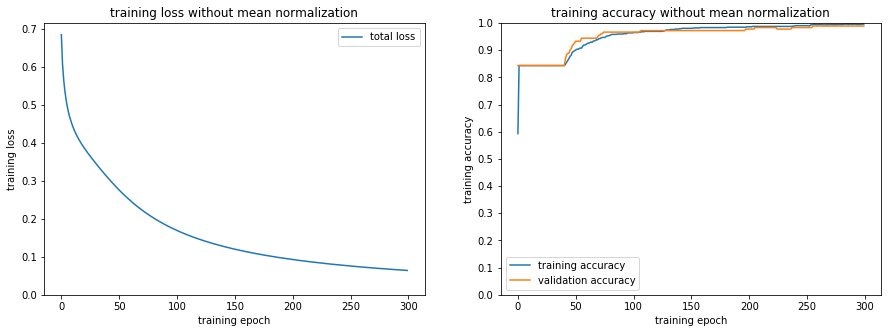

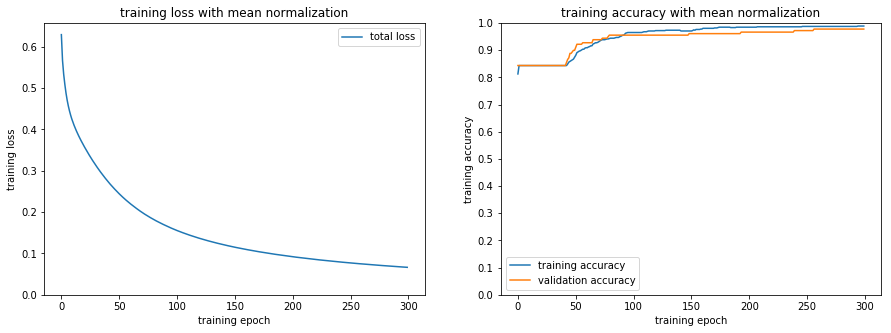

In [374]:
with_normalizations = (False, True)
for with_normalization, history in zip(with_normalizations, histories):
    fig = plt.figure(figsize=(15, 5))
    fig.add_subplot(121)
    normalization_note = 'with{} mean normalization'.format(
        '' if with_normalization else 'out'
    )
    if True:
        losses = history.losses
        plt.plot(
            list(range(len(losses))),
            losses,
            label='total loss',
        )
        plt.legend()
        plt.title(f'training loss {normalization_note}')
        plt.xlabel('training epoch')
        plt.ylabel('training loss')
        _, t = plt.ylim()
        plt.ylim((0, t))

    fig.add_subplot(122)
    if True:
        accuracies = history.accuracies
        plt.plot(
            list(range(len(accuracies))),
            accuracies,
            label='training accuracy',
        )
        val_accs = history.val_accs
        plt.plot(
            list(range(len(val_accs))),
            val_accs,
            label='validation accuracy',
        )
        plt.title(f'training accuracy {normalization_note}')
        plt.xlabel('training epoch')
        plt.ylabel('training accuracy')
        plt.ylim((0, 1))
        plt.legend()
        step = .1
        plt.yticks(np.arange(0, 1+step, step))

    print(f'training accuracy  : {dnn.evaluate(X_train, y_train, verbose=0)[1]:.3f}%')
    print(f'validation accuracy: {dnn.evaluate(X_test, y_test, verbose=0)[1]:.3f}%')


## Review misclassified articles

In [375]:
preds = (dnn.predict(X_test) >.5).reshape(-1)
missclassified_aids = aids_test#[preds != y_test]
aids_test_list = list(aids_test)
misclassified_test_indices = [aids_test_list.index(aid) for aid in missclassified_aids]

cursor_chromatic.execute('''
    select full_text, newsletter_archives.name
    from articles
    inner join newsletters using(nlid)
    inner join newsletter_archives using(nlaid)
    where aid=any(%(aids)s)
    order by nlaid
''', vars={'aids': list(map(int, missclassified_aids))})
last_nla_name = None

for (full_text, nla_name), misclassified_X in zip(cursor_chromatic, X_test[misclassified_test_indices]):
    if nla_name != last_nla_name:
        last_nla_name = nla_name
        print( '######################################################################')
        print(f'###########  Newsletter Archive Name: {nla_name} #############')
        print( '######################################################################')

    print(f'aid: {aid}')

    # topics
    if True:
        print('Topics:')
        # de-normalize (put 0s back to 0)
        misclassified_X = misclassified_X-misclassified_X.min().reshape((-1,1))

        index_and_pct = list()
        for i, v in enumerate(misclassified_X[0]):
            if v != 0:
                index_and_pct.append((i, v))
        index_and_pct = sorted(index_and_pct, key=lambda x: x[1], reverse=True)
        for i, pct in index_and_pct:
            print(f'{index_to_topic[i]: <12} {pct:.3f}')

    print('\nArticle:')
    print(full_text)
    print('##############################')

######################################################################
###########  Newsletter Archive Name: Unsupervised Learning Daniel Miessler #############
######################################################################
aid: 2674
Topics:
barbora      0.360
party        0.207
led          0.144
hugs         0.143

Article:
Every Sunday I put out a curated list of the most interesting stories in infosec, technology, and humans…
##############################
aid: 2674
Topics:
best         0.287
aged         0.206
career       0.175
going        0.166

Article:
More than 80,000 people in the US died from the flu last winter during what was a particularly nasty influenza season, the federal government estimated. It was the highest number reported in at least 40 years.

A Centers for Disease Control and Prevention spokesperson confirmed the estimated death toll, first reported by the Associated Press, to BuzzFeed News Wednesday.

"It was a really tough flu year," Colin Bucks, an

gives        0.013
large        0.013
warfare      0.012
still        0.012

Article:
As an inhabitant of planet Earth, I’ve heard a lot of people ask, “Can women really have it all?” and other people respond, “You can have it all, just not all at the same time.” Well, guess what, everyone. You’re wrong! I do have it all. Me! I have all of it.

I have two kids and the unspoken pressure to act like they don’t exist when I’m on a conference call.

I have a professional mandate to know what’s happening in pop culture and an eleven-year-old who tells me to “stop trying to act so cool.”

I have no problem lying about “being in a meeting” when I’m with my kids and no problem lying to my kids about “needing to work” when I’m on Facebook.

I have flexible morality and rigid immaturity.

I have kids who have forced me to do everything in my life with greater efficiency and the professional assumption that I’m now less efficient after having kids.

I have the beginnings of an old-lady stoop and 

participate  0.096
start        0.049
alone        0.039
throwing     0.034
environmental 0.033
muddy        0.033
mad          0.032
tired        0.029

Article:
Hi there, I know it’s been too long since my last article and for the people who follow me on a regular basis I am sorry that I can’t come…
##############################
aid: 2674
Topics:
military     0.314
impressive   0.141
term         0.131
gorillas     0.091
street       0.082
egan         0.046
sustainable  0.035
cited        0.035
r            0.034
trainer      0.033
gareth       0.024

Article:
BARCELONA, ESP – Today ASUS is launching a smartphone that is designed, according to the speaker at our prebriefing, to make it look like the user is holding an iPhone X. The new ASUS ZenFone 5, part of the ZenFone 5 family, comes with a notch. Apparently this is what the company says that its customers want: the ability to look as if you have an iPhone X, but have something else.

Aside from the notch, ASUS’ ZenFone 5 launch

# Keras 5-class topic classifier

In [89]:
dictionary

In [90]:
def get_bbc_data_X_y(dictionary):
    """
    convert bbc documents to a topic weight matrix, including a label array
    """
    bbc_doc_dir = os.path.join('bbc', 'bbc')
    dirs = [
        os.path.join(bbc_doc_dir, d)
        for d in (list(set(os.listdir(bbc_doc_dir)) - {'.DS_Store', 'README.TXT'}))
    ]
    classes = list()
    finished = False
    X_bbc = list()
    y_bbc = list()
    for i, directory in enumerate(dirs):
        for file in os.listdir(directory):
            full_path = os.path.join(directory, file)
            with open(full_path, 'r', errors='ignore') as fr:
                document = fr.read()
            twv = document_to_topic_weight_vector(dictionary, document)
            this_x = np.zeros(num_topics)
            for topic, percentage in twv:
                this_x[topic_to_index[topic]] = percentage
            X_bbc.append(this_x)
            y_bbc.append(i)
    X_bbc = np.c_[X_bbc]
    y_bbc = np.array(y_bbc)
    return X_bbc, y_bbc

In [91]:
%%time
X_bbc, y_bbc = get_bbc_data_X_y(dictionary)
X_bbc.shape, y_bbc.shape

CPU times: user 50.6 s, sys: 8.07 s, total: 58.7 s
Wall time: 15.5 s


In [92]:
class MultiCategoryHistory(keras.callbacks.Callback):
    # https://keras.io/callbacks/#example-recording-loss-history
    def __init__(self, logs=dict()):
        self.losses = list()
        self.accuracies = list()
        self.val_accs = list()

    def on_epoch_end(self, batch, logs=dict()):
        self.losses.append(logs.get('loss'))
        train_acc = logs.get('acc')
        self.accuracies.append(train_acc)

        metrics = dnn.evaluate(X_test_bbc, y_test_bbc, verbose=0)
        val_loss = metrics[0]
        val_acc = metrics[1]
        self.val_accs.append(val_acc)
#         print(f'validation accuracy - test accuracy = {val_acc-train_acc}')
#         if len(self.accuracies) > 1:
#             print(f'accuracy change: {self.accuracies[-1] - self.accuracies[-2]}')
#             print(f'val accuracy change: {self.val_accs[-1] - self.val_accs[-2]}')
#         print()

In [93]:
# mean_normalize = True
mean_normalize = False

if mean_normalize:
    # mean-normalize
    Xt_bbc = X_bbc - X_bbc.mean(axis=1).reshape((-1, 1))
else:
    Xt_bbc = X_bbc

In [94]:
one_hot_labels_bbc = keras.utils.to_categorical(y_bbc, num_classes=5)
X_train_bbc, X_test_bbc, y_train_bbc, y_test_bbc = train_test_split(
    Xt_bbc, one_hot_labels_bbc, stratify=y_bbc, test_size=.2
)

In [ ]:
%%time
dnn_epochs = 20

cvscores = list()
for train_indices, test_indices in kfold.split(Xt_bbc, y_bbc):
    print('asdf')
#     fit(
#         Xt_bbc[train_indices], one_hot_labels_bbc[train_indices],
#         validation_data=[Xt_bbc[test_indices], one_hot_labels_bbc[test_indices]],
#     )
#     evaluate(
#         Xt_bbc[test_indices], one_hot_labels_bbc[test_indices], verbose=0
#     )
#     cvscores.append(keras_test_acc)
######################################################################
    dnn = keras.Sequential()

    dnn.add(keras.layers.Dense(10, input_dim=X_train_bbc.shape[1], activation='relu'))
    # dnn.add(keras.layers.Dense(100, activation='relu'))
    dnn.add(keras.layers.Dense(10, activation='relu'))
    dnn.add(keras.layers.Dense(10, activation='relu'))
    # dnn.add(keras.layers.Dense(10, activation='sigmoid'))
    # dnn.add(keras.layers.Dense(10, activation='sigmoid'))
    dnn.add(keras.layers.Dense(y_train_bbc.shape[1], activation='softmax'))
    dnn.compile(
        'rmsprop',
        # https://stats.stackexchange.com/a/234578/145493
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy, 'accuracy'],
    )
    history = MultiCategoryHistory()


    dnn.fit(
        Xt_bbc[train_indices], one_hot_labels_bbc[train_indices],
        # SGD
        batch_size=1,
        validation_data=[Xt_bbc[test_indices], one_hot_labels_bbc[test_indices]],
        epochs=dnn_epochs,
        verbose=0,
        callbacks=[history],
    )

    # keras_test_acc = dnn.evaluate(X_test_bbc, y_test_bbc, verbose=0)[dnn.metrics_names.index('acc')]
    # print(f'Keras test accuracy: {keras_test_acc:.3f}')


#     dnn.evaluate(Xt_bbc[test_indices], one_hot_labels_bbc[test_indices])
    cvscores.append(dnn.evaluate(Xt_bbc[test_indices], one_hot_labels_bbc[test_indices])[1:])
# print(f"Keras CV accuracy: {np.mean(cvscores):.2f} (+/- {np.std(cvscores):.3f})")


In [122]:
mean, std = np.stack((np.array(cvscores).mean(axis=0), np.array(cvscores).std(axis=0))).T.round(3)[0]
print(f"Categorical accuracy: {mean}±{std}")

Categorical accuracy: 0.924±0.017


In [383]:
%%time
dnn_epochs = 200

dnn.fit(
    X_train_bbc, y_train_bbc,
    # SGD
    batch_size=1,
    validation_data=[X_test_bbc, y_test_bbc],
    epochs=dnn_epochs,
    verbose=1,
    callbacks=[history],
)

# keras_test_acc = dnn.evaluate(X_test_bbc, y_test_bbc, verbose=0)[dnn.metrics_names.index('acc')]
# print(f'Keras test accuracy: {keras_test_acc:.3f}')


dnn.evaluate(X_test_bbc, y_test_bbc)

Train on 1780 samples, validate on 445 samples
Epoch 1/200
1780/1780 [==============================] - 11s 6ms/step - loss: 1.4797 - categorical_accuracy: 0.3562 - acc: 0.3562 - val_loss: 1.2045 - val_categorical_accuracy: 0.4876 - val_acc: 0.4876
validation accuracy - test accuracy = 0.13146067429124636

Epoch 2/200
1780/1780 [==============================] - 8s 5ms/step - loss: 0.9610 - categorical_accuracy: 0.5871 - acc: 0.5871 - val_loss: 0.8586 - val_categorical_accuracy: 0.6247 - val_acc: 0.6247
validation accuracy - test accuracy = 0.037640450509746404
accuracy change: 0.2308988764044944
val accuracy change: 0.13707865262299446

Epoch 3/200
1780/1780 [==============================] - 8s 4ms/step - loss: 0.6841 - categorical_accuracy: 0.7449 - acc: 0.7449 - val_loss: 0.6845 - val_categorical_accuracy: 0.7685 - val_acc: 0.7685
validation accuracy - test accuracy = 0.023595504948262458
accuracy change: 0.15786516853932575
val accuracy change: 0.1438202229778418

Epoch 4/200
1780

KeyboardInterrupt: 

training accuracy  : 0.935%
validation accuracy: 0.888%


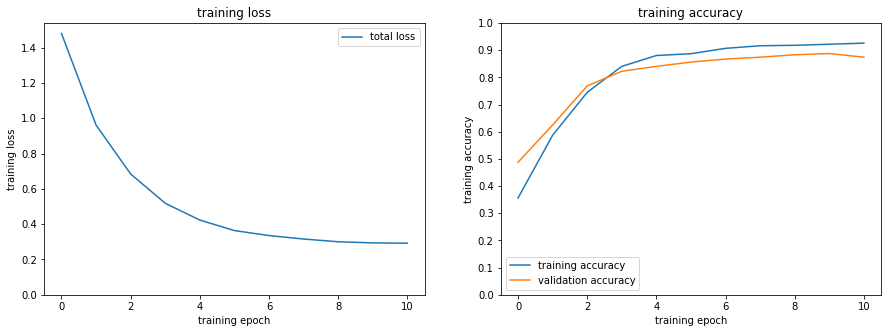

In [384]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)

# loss
if True:
    losses = history.losses
    plt.plot(
        list(range(len(losses))),
        losses,
        label='total loss',
    )
    plt.legend()
    plt.title(f'training loss')
    plt.xlabel('training epoch')
    plt.ylabel('training loss')
    _, t = plt.ylim()
    plt.ylim((0, t))

# accuracy
fig.add_subplot(122)
if True:
    accuracies = history.accuracies
    plt.plot(
        list(range(len(accuracies))),
        accuracies,
        label='training accuracy',
    )
    val_accs = history.val_accs
    plt.plot(
        list(range(len(val_accs))),
        val_accs,
        label='validation accuracy',
    )
    plt.title(f'training accuracy')
    plt.xlabel('training epoch')
    plt.ylabel('training accuracy')
    plt.ylim((0, 1))
    plt.legend()
    step = .1
    plt.yticks(np.arange(0, 1+step, step))

print(f'training accuracy  : {dnn.evaluate(X_train_bbc, y_train_bbc, verbose=0)[1]:.3f}%')
print(f'validation accuracy: {dnn.evaluate(X_test_bbc, y_test_bbc, verbose=0)[1]:.3f}%')

In [387]:
# closer to 0 is better, 0 is best
1 - sum([v[1] for v in twv])

0.01259741559624672

In [ ]:
y_train_bbc, y_test_bbc

In [388]:
y_test_bbc

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [391]:
y_train_labels = y_train_bbc.argmax(axis=1)
y_test_labels = y_test_bbc.argmax(axis=1)


In [397]:
y_train_labels

array([3, 4, 4, ..., 3, 4, 0])

In [427]:
bbc_data = pd.DataFrame(np.array([
    pd.Series(y_train_labels).value_counts().sort_index(),
    pd.Series(y_test_labels).value_counts().sort_index(),
]).T).T
bbc_data.columns = 'Business Sport Politics Entertainment  Tech'.split()
bbc_data = bbc_data.T
bbc_data.columns = 'Train Test'.split()
bbc_data['Percent test'] = (bbc_data.Test/(bbc_data.Test+bbc_data.Train)).round(2)
bbc_data['Total'] = bbc_data.Train + bbc_data.Test
cols = list(bbc_data.columns)
cols.pop(cols.index('Total'))
cols.insert(0, 'Total')
bbc_data = bbc_data[cols]
bbc_data

,Total,Train,Test,Percent test
Business,510,408,102,0.2
Sport,511,409,102,0.2
Politics,417,333,84,0.2
Entertainment,386,309,77,0.2
Tech,401,321,80,0.2


# Keras with CV

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x , y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Defind the build function to be passed to the KerasClassifier to guide the architecture of ANN
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(kernel_initializer='uniform', activation='relu', input_dim = 11, units = 6))
    #classifier.add(Dropout(rate=0.1)) # Not required here.
    classifier.add(Dense(kernel_initializer='uniform', activation='relu', units=6))
    #classifier.add(Dropout(rate=0.1)) # Not required here.
    classifier.add(Dense(kernel_initializer='uniform', activation='sigmoid', units= 1))
    classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_classifier, batch_size = 10, epochs = 50)
accuracies = cross_val_score(estimator= classifier, X= x_train, y= y_train, cv = 10, n_jobs =-1)

mean = accuracies.mean()
variance = accuracies.std()

y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import confusion_matrix
pred_matrix = confusion_matrix(y_test, y_pred)

Final_Accuracy = (pred_matrix[0,0] + pred_matrix[1,1])/x_test.shape[0] * 100